In [1]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=e2da747e210d1eca6d45bb74d231d56f563a2226158b70008237fac5d3d0448d
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [2]:
import numpy as np
import imageio

video = imageio.get_reader('/content/WhatsApp Video 2024-02-20 at 7.21.30 PM.mp4', 'ffmpeg')

In [6]:
colors = {'red': [], 'green': [], 'blue': []}
for frame in video:
    # Average all pixels
    lumped_pixel = np.mean(frame, axis=(0,1))
    colors['red'].append(lumped_pixel[0])
    colors['green'].append(lumped_pixel[1])
    colors['blue'].append(lumped_pixel[2])

In [7]:
len(colors["red"])

457

In [8]:
for key in colors:
    colors[key] = np.divide(colors[key], 255)

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fps = 30 # frames-per-second from video
x = np.arange(len(colors['red'])) / fps

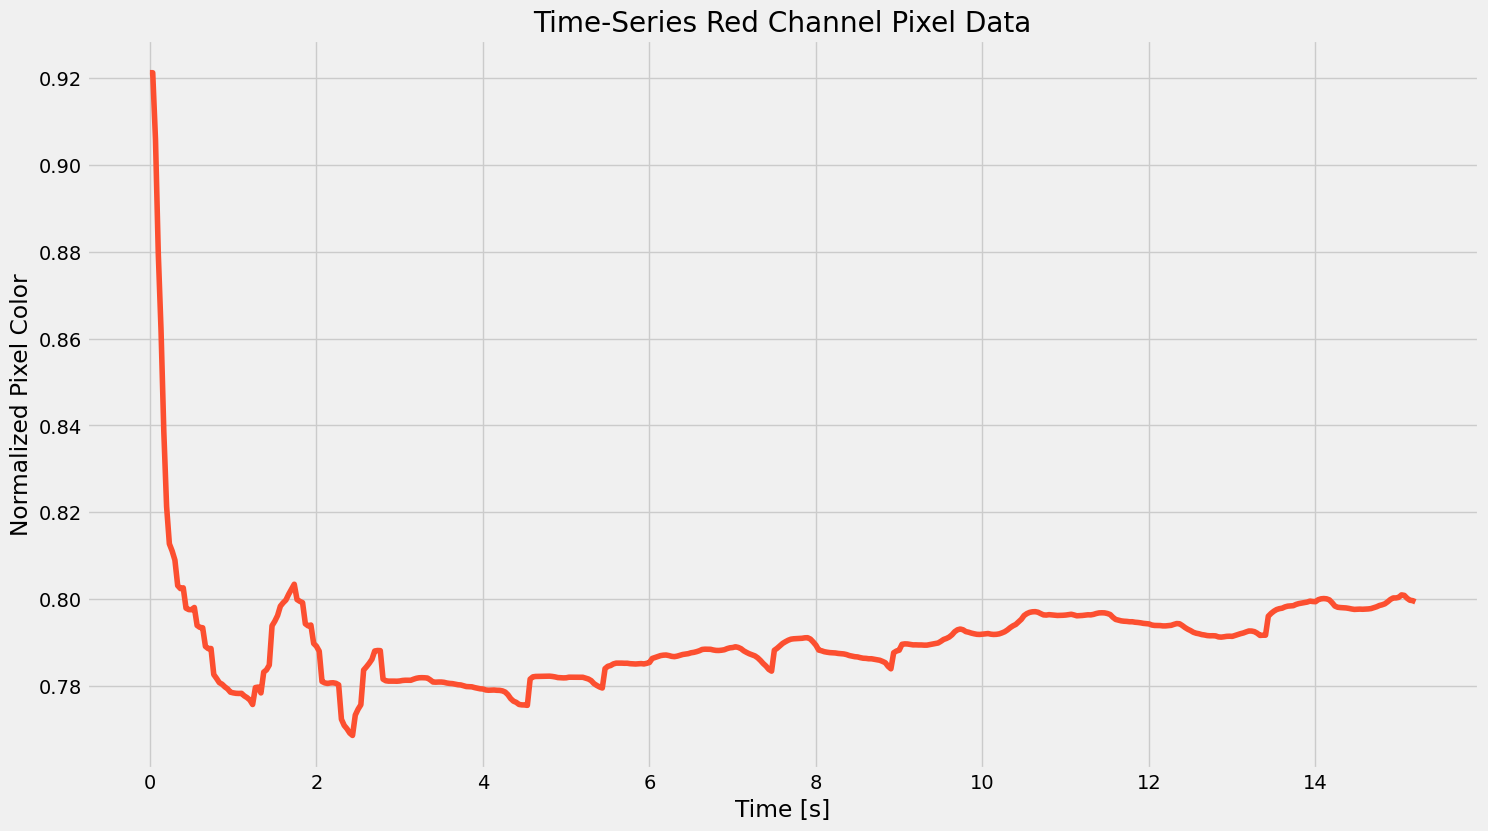

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(16,9))
plt.plot(x, colors['red'], color='#fc4f30')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Pixel Color')
plt.title('Time-Series Red Channel Pixel Data')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("Time_series_plot.png", dpi=200)

In [12]:
colors['red_filt'] = list()
colors['red_filt'] = np.append(colors['red_filt'], colors['red'][0])
tau = 0.25 # HPF time constant in seconds
fsample = fps # Sample rate
alpha = tau / (tau + 2/fsample)
for index, frame in enumerate(colors['red']):
    if index > 0:
        y_prev = colors['red_filt'][index - 1]
        x_curr = colors['red'][index]
        x_prev = colors['red'][index - 1]
        colors['red_filt'] = np.append(colors['red_filt'], alpha * (y_prev + x_curr - x_prev))

# Want to truncate data since beginning of series will be wonky
x_filt = x[50:-1]
colors['red_filt'] = colors['red_filt'][50:-1]

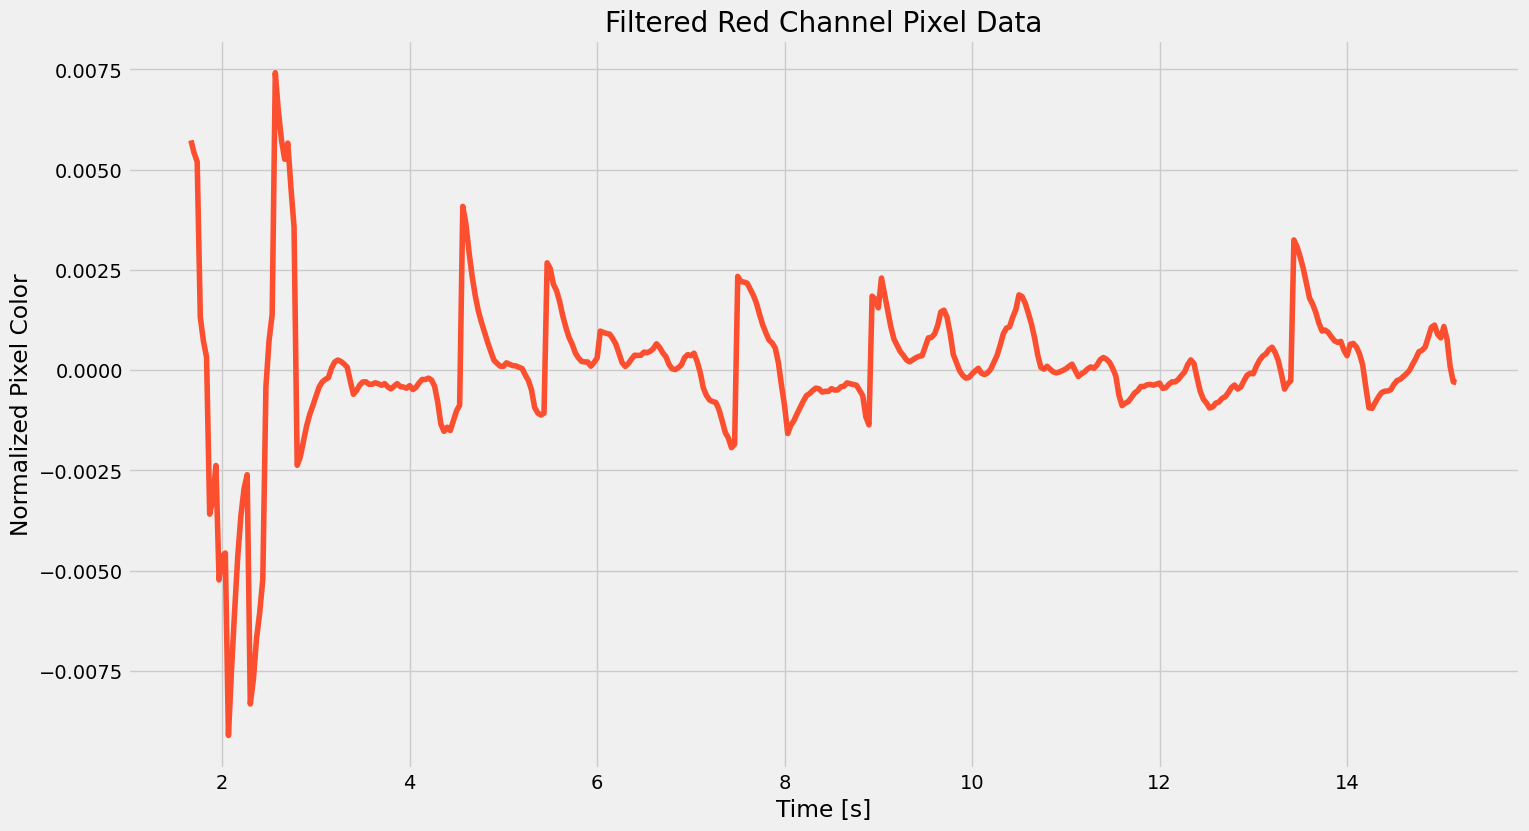

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(16,9))
plt.plot(x_filt, colors['red_filt'], color='#fc4f30')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Pixel Color')
plt.title('Filtered Red Channel Pixel Data')
fig2 = plt.gcf()
plt.show()
plt.draw()
fig2.savefig('filtered.png', dpi=200)

In [14]:
red_fft = np.absolute(np.fft.fft(colors['red_filt']))
N = len(colors['red_filt'])
freqs = np.arange(0,fsample/2,fsample/N)

# Truncate to fs/2
red_fft = red_fft[0:len(freqs)]

# Get heartrate from FFT
max_val = 0
max_index = 0
for index, fft_val in enumerate(red_fft):
    if fft_val > max_val:
        max_val = fft_val
        max_index = index

heartrate = round(freqs[max_index] * 60,1)
print('Estimated Heartate: {} bpm'.format(heartrate))

Estimated Heartate: 39.9 bpm


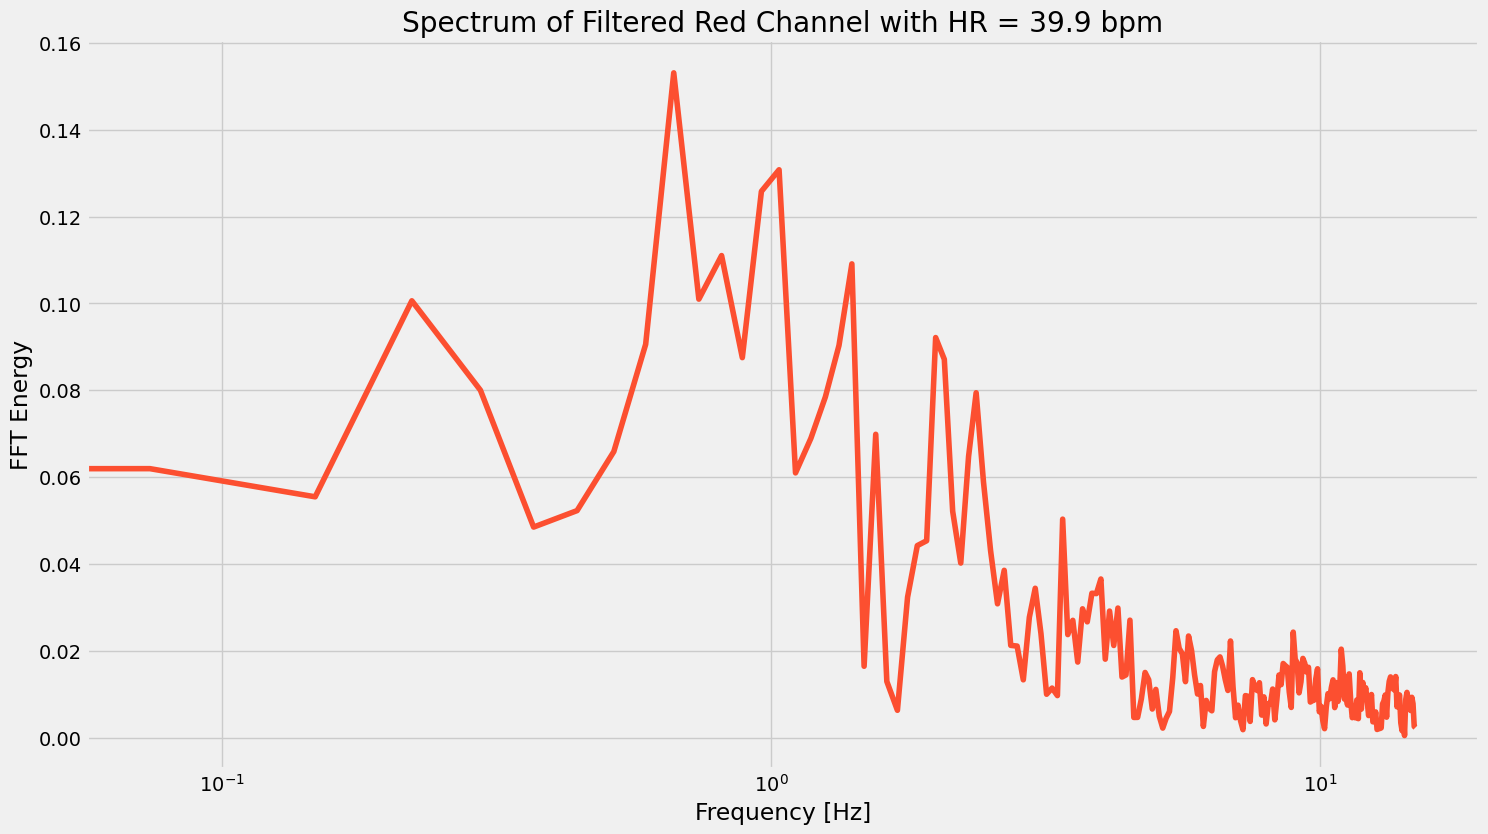

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(16,9))
plt.semilogx(freqs, red_fft, color='#fc4f30')
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT Energy')
plt.title('Spectrum of Filtered Red Channel with HR = {} bpm'.format(heartrate))
fig3 = plt.gcf()
plt.show()
plt.draw()
fig3.savefig('fft.png', dpi=200)